# Midterm

In [6]:
import pandas as pd
import seaborn as sns

In [68]:
df = pd.read_csv('/Users/kishanharavupradeep/Downloads/anomaly_detection.csv')
df.date = pd.to_datetime(df.date)

df.head()

,date,value,agency,anomaly
0,2020-01-01,197,AAA,0
1,2020-01-01,404,CCC,0
2,2020-01-01,153,BBB,0
3,2020-01-02,205,AAA,0
4,2020-01-02,401,CCC,0


In [70]:
df.query('anomaly == 1')

,date,value,agency,anomaly
24,2020-01-09,167,BBB,1
25,2020-01-09,411,CCC,1
26,2020-01-09,222,AAA,1
30,2020-01-11,390,CCC,1
31,2020-01-11,143,BBB,1
...,...,...,...,...
5557,2025-01-26,346,AAA,1
5558,2025-01-26,194,BBB,1
5562,2025-01-28,186,BBB,1
5563,2025-01-28,255,CCC,1


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     5574 non-null   datetime64[ns]
 1   value    5574 non-null   int64         
 2   agency   5574 non-null   object        
 3   anomaly  5574 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 174.3+ KB


In [80]:
import pandas as pd

# Assuming the dataset has already been loaded into df
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Sort the dataset by date to ensure proper time sequence
df = df.sort_values(by='date')

# Feature 1: Rolling Mean and Rolling Standard Deviation (over a window, e.g., 7 days)
df['rolling_mean'] = df['value'].rolling(window=7, min_periods=1).mean()
df['rolling_std'] = df['value'].rolling(window=7, min_periods=1).std()

# Feature 2: Lag Feature (previous day value)
df['lag_1'] = df['value'].shift(1)

# Feature 3: Day of the Week (e.g., Monday = 0, Sunday = 6)
df['day_of_week'] = df['date'].dt.dayofweek

# Feature 4: Day of the Year (from 1 to 365/366)
df['day_of_year'] = df['date'].dt.dayofyear

# Feature 5: Year and Month (could capture seasonal effects)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Feature 6: Trend (difference from previous day, captures daily changes)
df['trend'] = df['value'].diff()

# Feature 7: Previous Anomaly (this could capture the trend in anomalies)
df['prev_anomaly'] = df['anomaly'].shift(1)

# Feature 8: Moving Average for the Anomaly (captures longer-term anomaly behavior)
df['anomaly_rolling_mean'] = df['anomaly'].rolling(window=7, min_periods=1).mean()

# Drop rows with NaN values generated by shifting or rolling operations (if any)
df = df.dropna()

# Display the resulting dataframe with new features
df.head()


,date,value,agency,anomaly,rolling_mean,rolling_std,lag_1,day_of_week,day_of_year,year,month,trend,prev_anomaly,anomaly_rolling_mean
2,2020-01-01,153,BBB,0,278.50,177.483802,404.0,2,1,2020,1,-251.0,0.0,0.0
3,2020-01-02,205,AAA,0,254.00,132.480187,153.0,3,2,2020,1,52.0,0.0,0.0
4,2020-01-02,401,CCC,0,290.75,130.778120,205.0,3,2,2020,1,196.0,0.0,0.0
5,2020-01-02,150,BBB,0,262.60,129.573531,401.0,3,2,2020,1,-251.0,0.0,0.0
6,2020-01-03,205,AAA,0,253.00,118.255655,150.0,4,3,2020,1,55.0,0.0,0.0


In [82]:
df.shape

(5572, 14)

In [85]:
# Assuming df is the dataframe with new features added

# Set the split ratio (e.g., 80-20)
split_ratio = 0.8

# Calculate the index for the split (80% of the data for training, 20% for testing)
train_size = int(len(df) * split_ratio)

# Split the data (preserve time order, no shuffling)
train_data = df[:train_size]
test_data = df[train_size:]

# Display the shape of train and test sets
print(f"Training Data Size: {train_data.shape}")
print(f"Test Data Size: {test_data.shape}")

# Optional: Reset the index for better handling
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


Training Data Size: (4457, 14)
Test Data Size: (1115, 14)


In [87]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Assuming you have already split the data into train_data and test_data

# Define the features (X) and target variable (y)
X_train = train_data[['rolling_mean', 'rolling_std', 'lag_1', 'day_of_week', 
                      'day_of_year', 'year', 'month', 'trend', 'prev_anomaly', 
                      'anomaly_rolling_mean']]
y_train = train_data['anomaly']

X_test = test_data[['rolling_mean', 'rolling_std', 'lag_1', 'day_of_week', 
                    'day_of_year', 'year', 'month', 'trend', 'prev_anomaly', 
                    'anomaly_rolling_mean']]
y_test = test_data['anomaly']

# Initialize the Decision Tree model
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.8601

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       629
           1       0.84      0.84      0.84       486

    accuracy                           0.86      1115
   macro avg       0.86      0.86      0.86      1115
weighted avg       0.86      0.86      0.86      1115



In [89]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming you have already split the data into train_data and test_data

# Define the features (X) and target variable (y)
X_train = train_data[['rolling_mean', 'rolling_std', 'lag_1', 'day_of_week', 
                      'day_of_year', 'year', 'month', 'trend', 'prev_anomaly', 
                      'anomaly_rolling_mean']]
y_train = train_data['anomaly']

X_test = test_data[['rolling_mean', 'rolling_std', 'lag_1', 'day_of_week', 
                    'day_of_year', 'year', 'month', 'trend', 'prev_anomaly', 
                    'anomaly_rolling_mean']]
y_test = test_data['anomaly']

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Threshold the predictions (assuming values >= 0.5 are anomalies)
y_pred_class = np.where(y_pred >= 0.5, 1, 0)

# Evaluate the model (you can use classification metrics on the thresholded predictions)
accuracy = np.mean(y_pred_class == y_test)
print(f"Accuracy: {accuracy:.4f}")

# Optionally: Display regression evaluation metrics (for regression models)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nMean Squared Error:", mse)
print("R2 Score:", r2)

# You can also display the confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))


Accuracy: 0.8457

Mean Squared Error: 0.12903032221471886
R2 Score: 0.4752473966273665

Confusion Matrix:
[[543  86]
 [ 86 400]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       629
           1       0.82      0.82      0.82       486

    accuracy                           0.85      1115
   macro avg       0.84      0.84      0.84      1115
weighted avg       0.85      0.85      0.85      1115



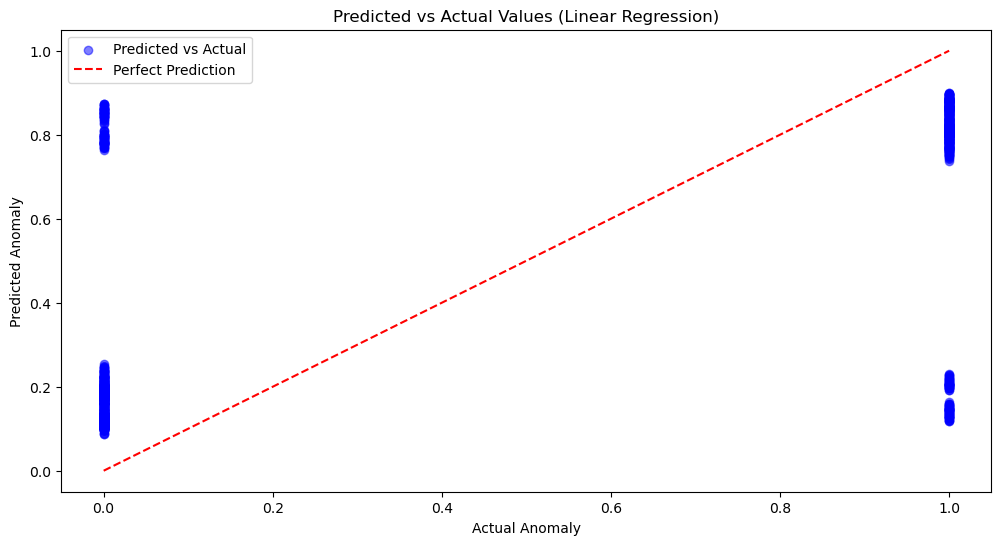

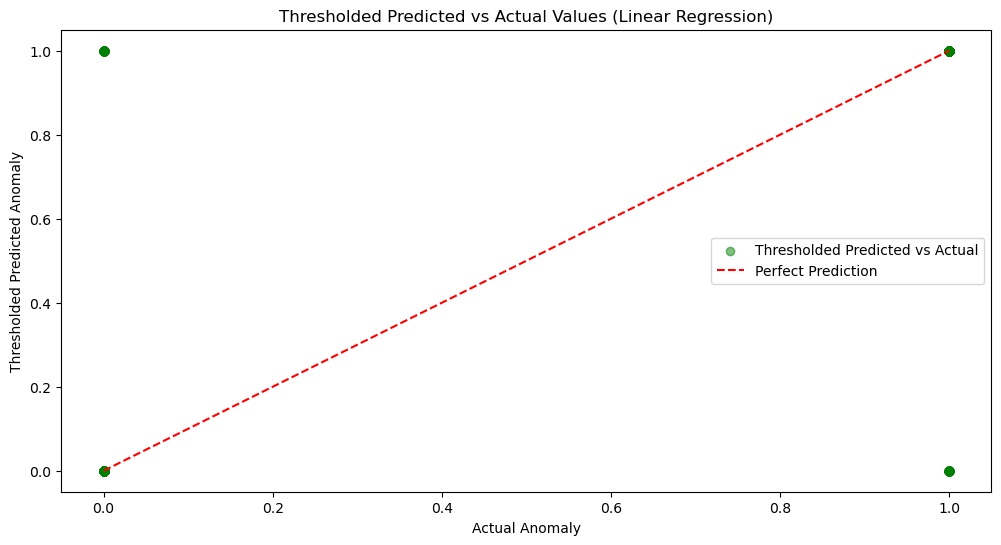

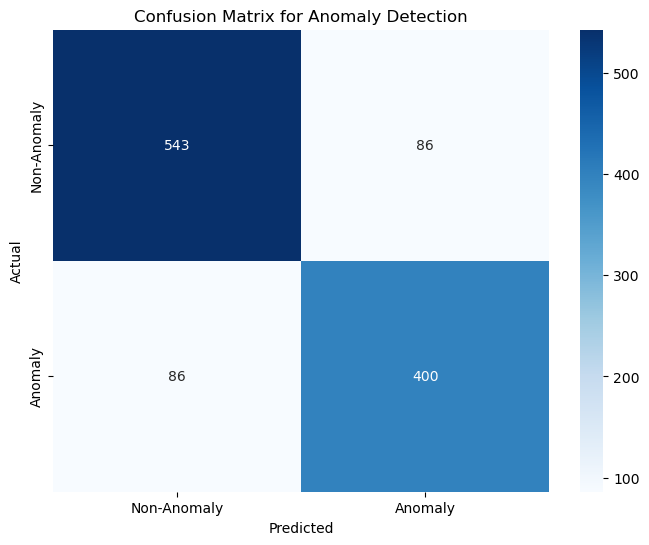

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

# Predicted vs Actual values (regression view)
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual Values (Linear Regression)')
plt.xlabel('Actual Anomaly')
plt.ylabel('Predicted Anomaly')
plt.legend()
plt.show()

# Thresholded Predictions vs Actual values (classification view)
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_class, color='green', alpha=0.5, label='Thresholded Predicted vs Actual')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Thresholded Predicted vs Actual Values (Linear Regression)')
plt.xlabel('Actual Anomaly')
plt.ylabel('Thresholded Predicted Anomaly')
plt.legend()
plt.show()

# Plotting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Anomaly', 'Anomaly'], yticklabels=['Non-Anomaly', 'Anomaly'])
plt.title('Confusion Matrix for Anomaly Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Accuracy: 0.8673

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       629
           1       0.86      0.83      0.84       486

    accuracy                           0.87      1115
   macro avg       0.87      0.86      0.86      1115
weighted avg       0.87      0.87      0.87      1115



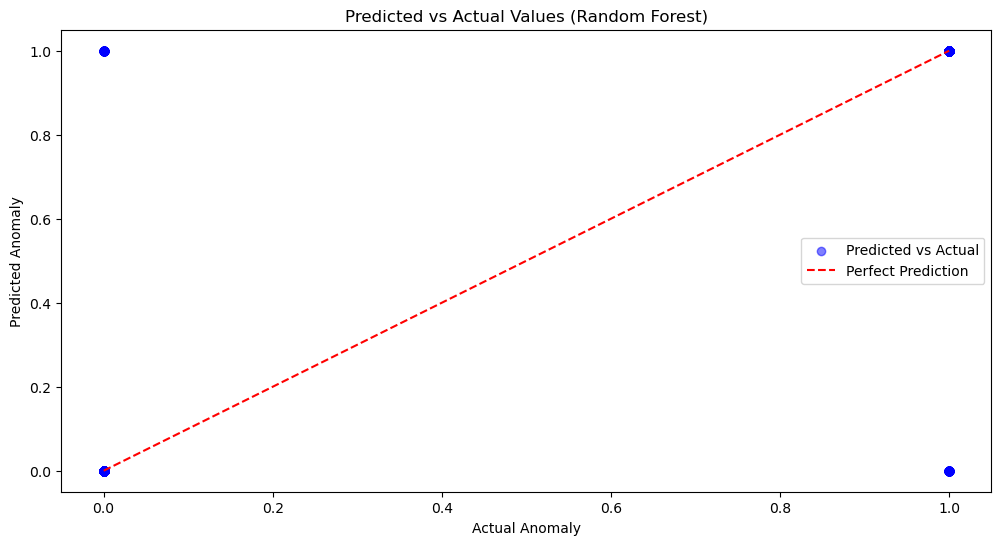

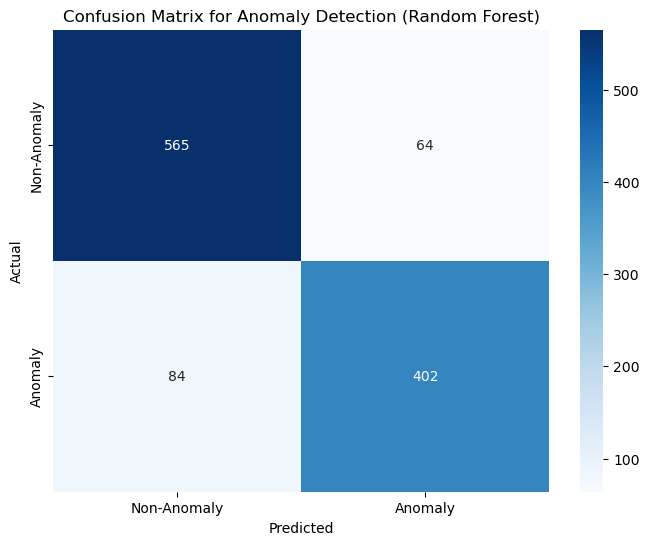

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already split the data into train_data and test_data

# Define the features (X) and target variable (y)
X_train = train_data[['rolling_mean', 'rolling_std', 'lag_1', 'day_of_week', 
                      'day_of_year', 'year', 'month', 'trend', 'prev_anomaly', 
                      'anomaly_rolling_mean']]
y_train = train_data['anomaly']

X_test = test_data[['rolling_mean', 'rolling_std', 'lag_1', 'day_of_week', 
                    'day_of_year', 'year', 'month', 'trend', 'prev_anomaly', 
                    'anomaly_rolling_mean']]
y_test = test_data['anomaly']

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plotting Predicted vs Actual values (classification view)
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Predicted vs Actual Values (Random Forest)')
plt.xlabel('Actual Anomaly')
plt.ylabel('Predicted Anomaly')
plt.legend()
plt.show()

# Plotting confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Anomaly', 'Anomaly'], yticklabels=['Non-Anomaly', 'Anomaly'])
plt.title('Confusion Matrix for Anomaly Detection (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


<Axes: xlabel='date', ylabel='value'>

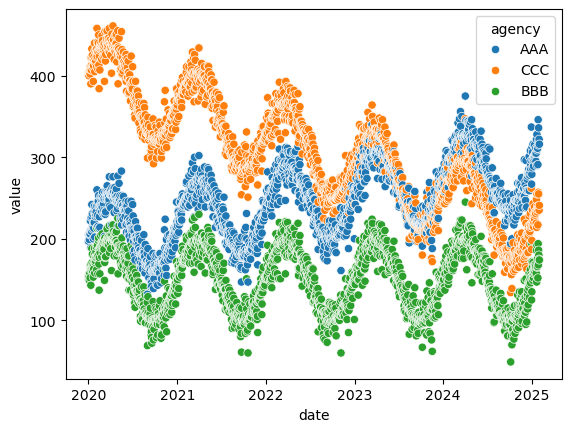

In [16]:
sns.scatterplot(data=df, x='date', y='value', hue='agency')

<Axes: xlabel='date', ylabel='value'>

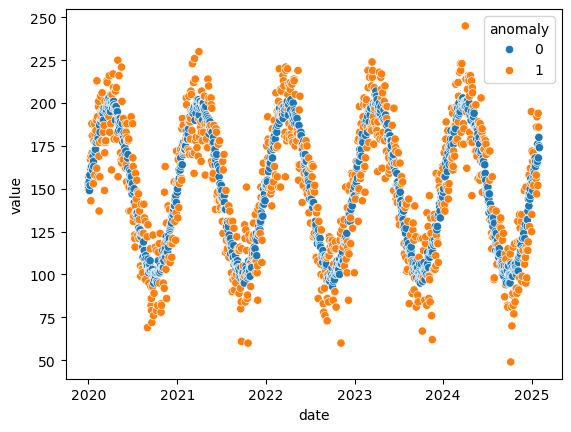

In [18]:
sns.scatterplot(data=df.query("agency=='BBB'"), x='date', y='value', hue='anomaly')